<a href="https://colab.research.google.com/github/kk-shetty/data_science_ik/blob/main/projects/ml_mini_project/node_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Mini Project - **Understanding Networks through Clustering**.
## Leveraging Local Node Features for Structural Profiling

## 1. Data Loading and Library Import

In this section, we import the necessary libraries and load the data into Google Colab from Google Drive. We use the `google.colab.drive` module to access files stored in Google Drive, and the `networkx` and `pandas` libraries for working with network data and data analysis, respectively.


In [1]:
# Importing necessary libraries
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Mounting Google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading edge file
# file_url = '/content/drive/My Drive/ml_mini_project_data/soc-karate.txt'
file_url = '/content/drive/My Drive/ml_mini_project_data/facebook_combined.txt'
network = nx.read_edgelist(file_url)

In [ ]:
# Basic details about the network
print("Number of nodes:", network.number_of_nodes())
print("Number of edges:", network.number_of_edges())

Number of nodes: 4039
Number of edges: 88234


In [ ]:
# Only use for sample files with fewer than 500 nodes

# Plotting the network for visualization
# plt.figure(figsize=(6,6))
# pos = nx.fruchterman_reingold_layout(network)
# pos = nx.kamada_kawai_layout(network)
# pos = nx.random_layout(network)
# nx.draw(network, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='black', linewidths=1, font_size=10)
# plt.title("Graph Visualization")
# plt.show()

## 2. Extracting Local Features from the Network

In this section, we extract local features for each node in the network up to the fourth ego network (radius = 1 to 4). Local features capture the structural properties of the network neighborhood around each node, providing insights into its immediate connectivity and topology.

### Functions Used:

#### `extract_local_features(local_network, node, radius)`

This function computes various local features for a given node within its ego network of a specified radius. It calculates properties such as clustering coefficient, ego network size, density, number of triangles (closed triangles), number of bridges, centrality properties (radius, diameter, center), cycle basis count, and cycle counts of different lengths up to 6. The function returns a dictionary containing these features.

#### Usage:

We utilize the `extract_local_features` function to extract local features for each node in the network up to the fourth ego network. For each node, we iterate over ego networks of increasing radius, compute the local features using the function, and store the results in a dictionary.

### Steps:

1. **Iterate Over Nodes**: We iterate over each node in the network.
2. **Compute Local Features**: For each node, we compute local features within ego networks of radius 1 to 4 using the `extract_local_features` function.
3. **Create DataFrame**: We construct a pandas DataFrame from the computed local features dictionary, with nodes as rows and features as columns.

### Result:

The resulting DataFrame contains local features for each node, where each row represents a node and each column represents a local feature. This DataFrame serves as the basis for further analysis and modeling tasks, such as clustering nodes based on their structural similarities.

Let's take a sample of 20 rows from the DataFrame to examine the extracted local features.


In [ ]:
# Using tqdm package to track the progress
from tqdm import tqdm

In [ ]:
def extract_local_features(args):
    local_network, node, radius = args
    features = {}

    if radius == 1:
        features['node_clustering_coefficient'] = nx.clustering(local_network, node)

    features[f'EN{radius}_number_of_nodes'] = local_network.number_of_nodes()
    features[f'EN{radius}_number_of_edges'] = local_network.number_of_edges()
    features[f'EN{radius}_ego_density'] = nx.density(local_network)

    features[f'EN{radius}_triangles_count'] = sum(nx.triangles(local_network).values()) // 3

    features[f'EN{radius}_bridges_count'] = len(list(nx.bridges(local_network)))

    features[f'EN{radius}_is_center'] = 1 if node in nx.center(local_network) else 0
    features[f'EN{radius}_radius'] = nx.radius(local_network)
    features[f'EN{radius}_diameter'] = nx.diameter(local_network)

    cycle_basis_lengths = [len(cycle) for cycle in nx.cycle_basis(local_network)]
    features[f'EN{radius}_cycle_basis_count'] = len(cycle_basis_lengths)
    features[f'EN{radius}_max_cycle_basis'] = max(cycle_basis_lengths, default=0)

    return features

In [ ]:
# Using the above function to extract the local featrures for 1st ego network and creating a data frame using all the features as columns.
def ego_network_features(ego_radius):
    local_features = {}

    for node in tqdm(network.nodes(), desc="Processing nodes", unit="node"):
        local_features[node] = {}
        ego_network = nx.ego_graph(network, node, radius=ego_radius)
        local_features[node].update(extract_local_features((ego_network, node, ego_radius)))

    # Creating pandas dataframe from the features dictionary and saving into csv
    df = pd.DataFrame.from_dict(local_features, orient='index')
    df.index.name = 'node'
    df.reset_index(inplace=True)

    # Specify the path where you want to save the file in your Google Drive
    file_path = f'/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_{ego_radius}.csv'

    # Save the DataFrame to CSV without row index
    df.to_csv(file_path, index=False)

In [ ]:
# Calling the function to extract local features of different ego network.
# ego_network_features(1)
# ego_network_features(2)
# ego_network_features(3)
# ego_network_features(4)

Processing nodes: 100%|██████████| 4039/4039 [03:30<00:00, 19.21node/s] 


In [8]:
# Creating df from individual ego network feature csv file

df1 = pd.read_csv('/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_1.csv')
df2 = pd.read_csv('/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_2.csv')
df3 = pd.read_csv('/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_3.csv')
df4 = pd.read_csv('/content/drive/My Drive/ml_mini_project_data/facebook_combined_output_4.csv')

## 3. Feature Engineering

In [9]:
# Checking unique values for each of the features in each data frames and removing features with constand values
df1.nunique()

node                           4039
node_clustering_coefficient    2540
EN1_number_of_nodes             227
EN1_number_of_edges            1586
EN1_ego_density                2552
EN1_triangles_count            2422
EN1_bridges_count                12
EN1_is_center                     1
EN1_radius                        1
EN1_diameter                      2
EN1_cycle_basis_count          1559
EN1_max_cycle_basis              21
dtype: int64

In [10]:
# Check the distribution of EN1_diameter
df1.EN1_diameter.value_counts()

EN1_diameter
2    3697
1     342
Name: count, dtype: int64

In [11]:
df1.drop(columns=['EN1_is_center', 'EN1_radius'], inplace=True)

In [12]:
df2.nunique()

node                     4039
EN2_number_of_nodes       361
EN2_number_of_edges       501
EN2_ego_density           513
EN2_triangles_count       507
EN2_bridges_count          24
EN2_cycle_basis_count     501
EN2_max_cycle_basis        79
dtype: int64

In [13]:
df3.nunique()

node                     4039
EN3_number_of_nodes        63
EN3_number_of_edges        64
EN3_ego_density            64
EN3_triangles_count        64
EN3_bridges_count          28
EN3_cycle_basis_count      62
EN3_max_cycle_basis        31
dtype: int64

In [15]:
df4.nunique()

node                   4039
EN4_number_of_nodes      24
EN4_number_of_edges      24
EN4_ego_density          24
EN4_triangles_count      24
EN4_bridges_count        17
dtype: int64

In [16]:
# Performing correlation analysis between features of the each ego network

# Importing seaborn library to plot correlation matrix
import seaborn as sns

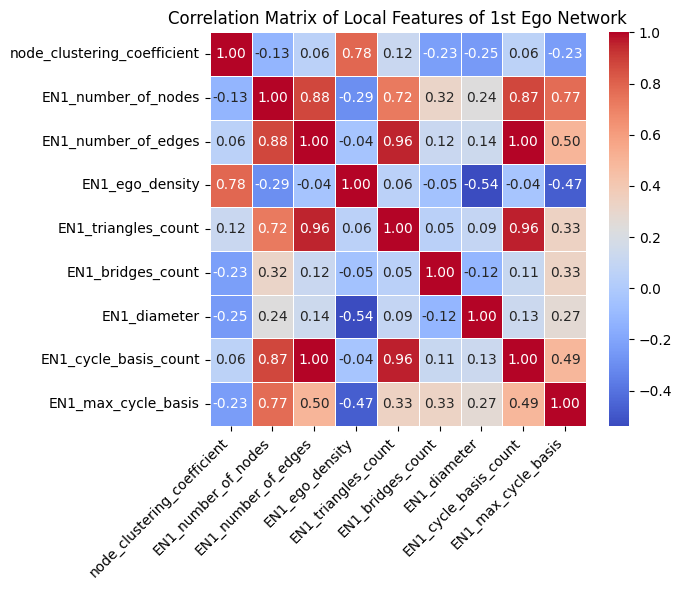

In [18]:
# Correlation matrics for 1st ego network features
plt.figure(figsize=(7, 6))
heatmap = sns.heatmap(df1.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 1st Ego Network')
plt.tight_layout()
plt.show()

In [19]:
# There is high correlation between below combinations:
# 1. EN1_number_of_edges and EN1_triangles_count
# 2. EN1_number_of_edges and EN1_cycle_basis_count
df1.drop(columns=['EN1_triangles_count','EN1_cycle_basis_count'], inplace=True)

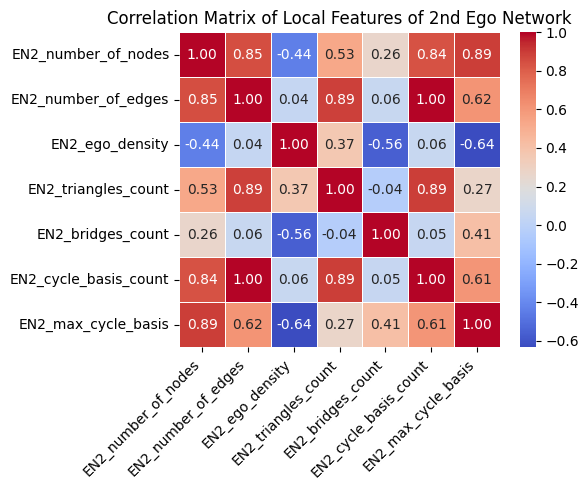

In [21]:
# Correlation matrics for 2nd ego network features
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(df2.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 2nd Ego Network')
plt.tight_layout()
plt.show()

In [23]:
# There is high correlation between below combinations:
# 1. EN2_number_of_edges and EN2_triangles_count
# 2. EN2_number_of_edges and EN2_cycle_basis_count
# 2. EN2_number_of_nodes and EN2_max_cycle_basis
df2.drop(columns=['EN2_triangles_count','EN2_cycle_basis_count','EN2_max_cycle_basis'], inplace=True)

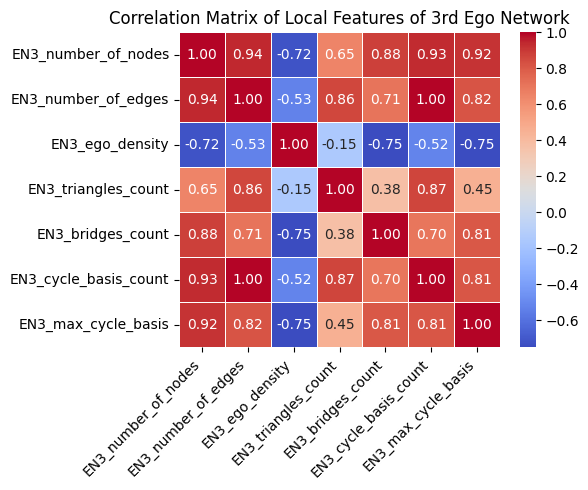

In [24]:
# Correlation matrics for 3rd ego network features
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(df3.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 3rd Ego Network')
plt.tight_layout()
plt.show()

In [25]:
# There is high correlation between below combinations:
# 1. EN3_number_of_edges and EN3_cycle_basis_count
# 2. EN3_number_of_nodes and EN3_max_cycle_basis
df3.drop(columns=['EN3_cycle_basis_count','EN3_max_cycle_basis'], inplace=True)

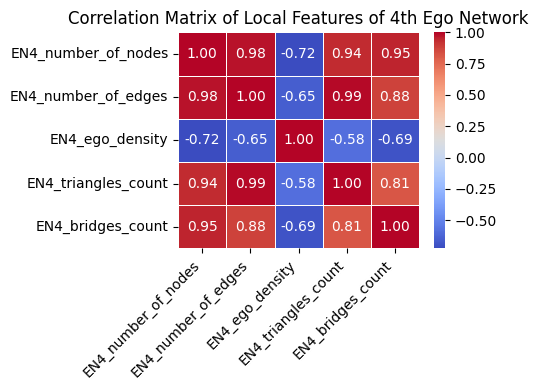

In [27]:
# Correlation matrics for 4th ego network features
plt.figure(figsize=(5, 4))
heatmap = sns.heatmap(df4.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 4th Ego Network')
plt.tight_layout()
plt.show()

In [28]:
# There is high correlation between below combinations:
# 1. EN4_number_of_edges and EN4_triangles_count
# 2. EN4_number_of_nodes and EN4_bridges_count
df4.drop(columns=['EN4_triangles_count','EN4_bridges_count'], inplace=True)

In [36]:
# Feature scaling : Since ego_density is in the scale of 0 to 1, it would be ideal to scale rest of the features to the same scale usin g min max scaling.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [37]:
# Ego network 1 features
features_to_scale = ['EN1_number_of_nodes', 'EN1_number_of_edges', 'EN1_bridges_count', 'EN1_max_cycle_basis']
# Fit and transform the selected features
scaled_features = scaler.fit_transform(df1[features_to_scale])
# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=[feat + '_scaled' for feat in features_to_scale])
# Append the scaled features to the original DataFrame
df1 = pd.concat([df1, scaled_df], axis=1)

In [40]:
# Ego network 2 features
features_to_scale = ['EN2_number_of_nodes', 'EN2_number_of_edges', 'EN2_bridges_count']
# Fit and transform the selected features
scaled_features = scaler.fit_transform(df2[features_to_scale])
# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=[feat + '_scaled' for feat in features_to_scale])
# Append the scaled features to the original DataFrame
df2 = pd.concat([df2, scaled_df], axis=1)

In [43]:
# Ego network 3 features
features_to_scale = ['EN3_number_of_nodes', 'EN3_number_of_edges', 'EN3_triangles_count', 'EN3_bridges_count']
# Fit and transform the selected features
scaled_features = scaler.fit_transform(df3[features_to_scale])
# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=[feat + '_scaled' for feat in features_to_scale])
# Append the scaled features to the original DataFrame
df3 = pd.concat([df3, scaled_df], axis=1)

In [45]:
# Ego network 4 features
features_to_scale = ['EN4_number_of_nodes', 'EN4_number_of_edges']
# Fit and transform the selected features
scaled_features = scaler.fit_transform(df4[features_to_scale])
# Convert scaled features to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=[feat + '_scaled' for feat in features_to_scale])
# Append the scaled features to the original DataFrame
df4 = pd.concat([df4, scaled_df], axis=1)

In [49]:
# Concatinating all the 4 dfs into a single df and then performing overall correlation analysis (on scaled features)
merged_df = pd.merge(df1, df2, on='node', how='inner')
merged_df = pd.merge(merged_df, df3, on='node', how='inner')
merged_df = pd.merge(merged_df, df4, on='node', how='inner')

In [50]:
merged_df.sample(5)

,node,node_clustering_coefficient,EN1_number_of_nodes,EN1_number_of_edges,EN1_ego_density,EN1_bridges_count,EN1_diameter,EN1_max_cycle_basis,EN1_number_of_nodes_scaled,EN1_number_of_edges_scaled,...,EN3_bridges_count,EN3_number_of_nodes_scaled,EN3_number_of_edges_scaled,EN3_triangles_count_scaled,EN3_bridges_count_scaled,EN4_number_of_nodes,EN4_number_of_edges,EN4_ego_density,EN4_number_of_nodes_scaled,EN4_number_of_edges_scaled
814,1328,0.636842,21,141,0.671429,0,2,5,0.018199,0.004549,...,55,0.832582,0.731094,0.521888,0.774194,3842,86408,0.011711,0.946929,0.978345
2735,3210,0.450549,15,55,0.523810,0,2,3,0.012452,0.001754,...,18,0.468825,0.492514,0.363544,0.177419,3327,81366,0.014706,0.808190,0.918550
1144,1658,0.485380,20,102,0.536842,0,2,4,0.017241,0.003281,...,43,0.695941,0.672405,0.506848,0.580645,3780,86055,0.012049,0.930226,0.974159
2670,3134,1.000000,3,3,1.000000,0,1,3,0.000958,0.000065,...,18,0.468825,0.492514,0.363544,0.177419,3327,81366,0.014706,0.808190,0.918550
1860,715,0.933333,11,52,0.945455,0,2,3,0.008621,0.001657,...,7,0.039002,0.020725,0.006074,0.000000,756,7352,0.025761,0.115571,0.040796


In [51]:
merged_df.nunique()

node                           4039
node_clustering_coefficient    2540
EN1_number_of_nodes             227
EN1_number_of_edges            1586
EN1_ego_density                2552
EN1_bridges_count                12
EN1_diameter                      2
EN1_max_cycle_basis              21
EN1_number_of_nodes_scaled      227
EN1_number_of_edges_scaled     1586
EN1_bridges_count_scaled         12
EN1_max_cycle_basis_scaled       21
EN2_number_of_nodes             361
EN2_number_of_edges             501
EN2_ego_density                 513
EN2_bridges_count                24
EN2_number_of_nodes_scaled      361
EN2_number_of_edges_scaled      501
EN2_bridges_count_scaled         24
EN3_number_of_nodes              63
EN3_number_of_edges              64
EN3_ego_density                  64
EN3_triangles_count              64
EN3_bridges_count                28
EN3_number_of_nodes_scaled       63
EN3_number_of_edges_scaled       64
EN3_triangles_count_scaled       64
EN3_bridges_count_scaled    

In [ ]:
# Correlation matrics for all 4 ego network features
features = []
plt.figure(figsize=(5, 4))
heatmap = sns.heatmap(df4.iloc[:,1:].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 4th Ego Network')
plt.tight_layout()
plt.show()

In [ ]:
# Let's remove feature with constant values
columns_to_drop = ['EN1_is_center', 'EN1_radius', 'EN4_bridges_count']
# df.drop(columns=['EN1_is_center', 'EN1_radius', 'EN4_bridges_count'], inplace=True)

In [ ]:
# Value counts of features with low variance
df[['EN1_diameter', 'EN1_max_cycle_basis', 'EN2_is_center', 'EN2_radius', 'EN2_diameter', 'EN3_is_center', 'EN3_radius', 'EN3_diameter', 'EN4_is_center', 'EN4_radius', 'EN4_diameter']].apply(pd.Series.value_counts)

,EN1_diameter,EN1_max_cycle_basis,EN2_is_center,EN2_radius,EN2_diameter,EN3_is_center,EN3_radius,EN3_diameter,EN4_is_center,EN4_radius,EN4_diameter
0,NaN,2.0,3.0,NaN,NaN,25.0,NaN,NaN,26.0,NaN,NaN
1,12.0,NaN,31.0,3.0,NaN,9.0,NaN,NaN,8.0,NaN,NaN
2,22.0,NaN,NaN,31.0,4.0,NaN,25.0,NaN,NaN,9.0,NaN
3,NaN,32.0,NaN,NaN,19.0,NaN,9.0,2.0,NaN,25.0,NaN
4,NaN,NaN,NaN,NaN,11.0,NaN,NaN,23.0,NaN,NaN,9.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,25.0


In [ ]:
# add columns to drop
columns_to_drop.extend(['EN1_max_cycle_basis', 'EN2_is_center', 'EN2_radius'])

In [ ]:
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Performing correlation analysis between ego network 1 features

# Importing seaborn library to plot correlation matrix
import seaborn as sns

en1_features = df.columns[2:12]

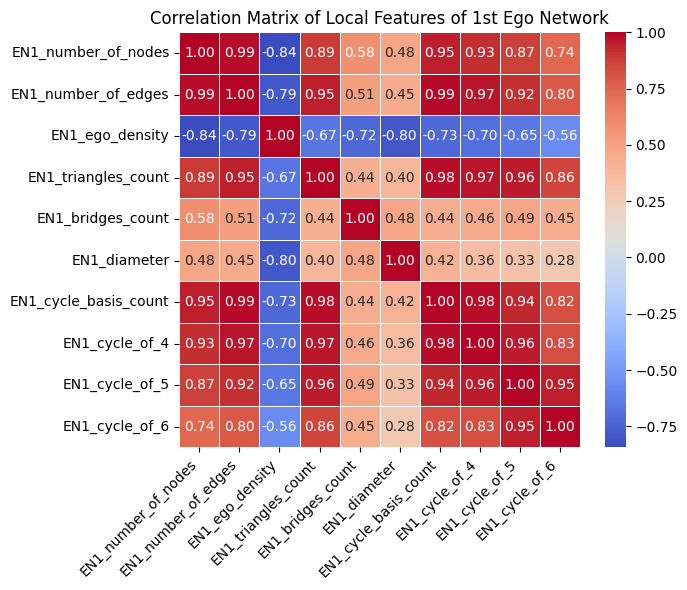

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(7, 6))
heatmap = sns.heatmap(df[en1_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Matrix of Local Features of 1st Ego Network')
plt.tight_layout()
plt.show()